# Neural Network Final Model - Gosan, South Korea

In [1]:
import pandas as pd
from joblib import dump
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

import sys
sys.path.append('../../')
import config

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [2]:
site = config.site
site_name = config.site_dict[site]
assert site == 'GSN', 'This script is only for Gosan, South Korea. The site can be changed in the config file.'

compound = config.compound

print(f"Creating a neural network model for \033[1m{site_name}\033[0;0m.")

Creating a neural network model for Gosan, South Korea.


### Loading & Initialising Data

In [3]:
data = pd.read_csv(data_path/f'for_model_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,flag,u10_0,u10_1,u10_2,u10_3,u10_4,u10_5,u10_6,u10_7,...,v500_2_past,v500_3_past,v500_4_past,v500_5_past,v500_6_past,v500_7_past,v500_8_past,v500_13_past,v500_14_past,v500_15_past
10563,2017-09-13 09:00:00,0.0,-2.609428,1.836746,-3.713417,-0.680469,-9.099390,-12.245153,-2.496611,-6.098676,...,-4.219768,3.275061,0.365661,2.728879,0.972529,-7.018505,0.960035,0.660170,6.835952,-3.491526
5930,2012-11-24 19:00:00,1.0,0.413681,-0.206393,3.228936,1.163706,2.120983,-2.472152,0.988943,-3.653484,...,-6.877046,-9.095465,-9.031342,-6.630418,-3.210923,-1.715125,-8.131149,-2.325529,2.142136,8.754229
8304,2015-02-06 19:00:00,1.0,4.687213,0.315978,3.011539,0.975310,1.086717,1.564251,0.801615,3.099653,...,-6.636755,2.036558,1.079724,-2.395095,-10.761673,-2.506116,4.421777,0.236199,-0.659975,-9.942183
6188,2013-01-24 19:00:00,1.0,5.317689,4.106913,13.940696,5.090399,8.759352,3.373338,-1.229010,0.577459,...,-3.243907,-12.138292,-7.066109,-1.222018,1.262292,-7.722409,-1.843397,2.179909,-0.775252,0.265196
10047,2017-02-09 03:00:00,1.0,6.381633,5.105897,-7.083622,5.546649,10.176229,7.038685,1.185165,8.332647,...,8.384868,13.421393,5.452887,1.159715,-17.862825,-6.004508,-13.000562,1.730025,-6.273821,-16.461422


In [4]:
train_data = data[(data['time'].dt.year >= 2009) & (data['time'].dt.year <= 2013)]
val_data = data[(data['time'].dt.year >= 2014) & (data['time'].dt.year <= 2014)]
test_data = data[(data['time'].dt.year >= 2015) & (data['time'].dt.year <= 2017)]

print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2009-01-01 01:00:00 -> 2013-12-30 09:00:00. Length: 5763
Val range: 2014-01-03 19:00:00 -> 2014-12-31 23:00:00. Length: 933
Test range: 2015-01-01 01:00:00 -> 2017-12-31 23:00:00. Length: 2824


### Model

In [27]:
nn_model = MLPClassifier(random_state=42,
                         max_iter=1000, 
                         hidden_layer_sizes=(100,), 
                         shuffle=False,
                         activation='relu', 
                         solver='adam', 
                         alpha=0.0001, 
                         learning_rate='constant', 
                         batch_size=100, 
                         early_stopping=False,
                         learning_rate_init=0.0001,
                         beta_2=0.9,)

nn_model.fit(X_train, y_train)

y_pred_val = nn_model.predict(X_val)
y_pred_train = nn_model.predict(X_train)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")

Precision on Training Set = 0.905
Precision on Validation Set = 0.879
Recall on Training Set = 0.715
Recall on Validation Set = 0.773
F1 Score on Training Set = 0.799
F1 Score on Validation Set = 0.823


In [28]:
# evaluating model on test set
y_pred_test = nn_model.predict(X_test)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Testing Set = {precision_test:.3f}")
print(f"Recall on Testing Set = {recall_test:.3f}")
print(f"F1 Score on Testing Set = {f1_test:.3f}")

Precision on Testing Set = 0.890
Recall on Testing Set = 0.770
F1 Score on Testing Set = 0.826


In [26]:
# saving the model
dump(nn_model, data_path/f'nn_model_GSN.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\nn_model_GSN.joblib']

### Assessing Feature Importance

In [29]:
# finding most important features in the model using permutation importance
# using the testing set
perm_importance = permutation_importance(nn_model, X_train, y_train, n_repeats=30, random_state=42)
sorted_importances = perm_importance.importances_mean.argsort()

Text(0.5, 1.0, 'Permutation Importance (Testing Set)')

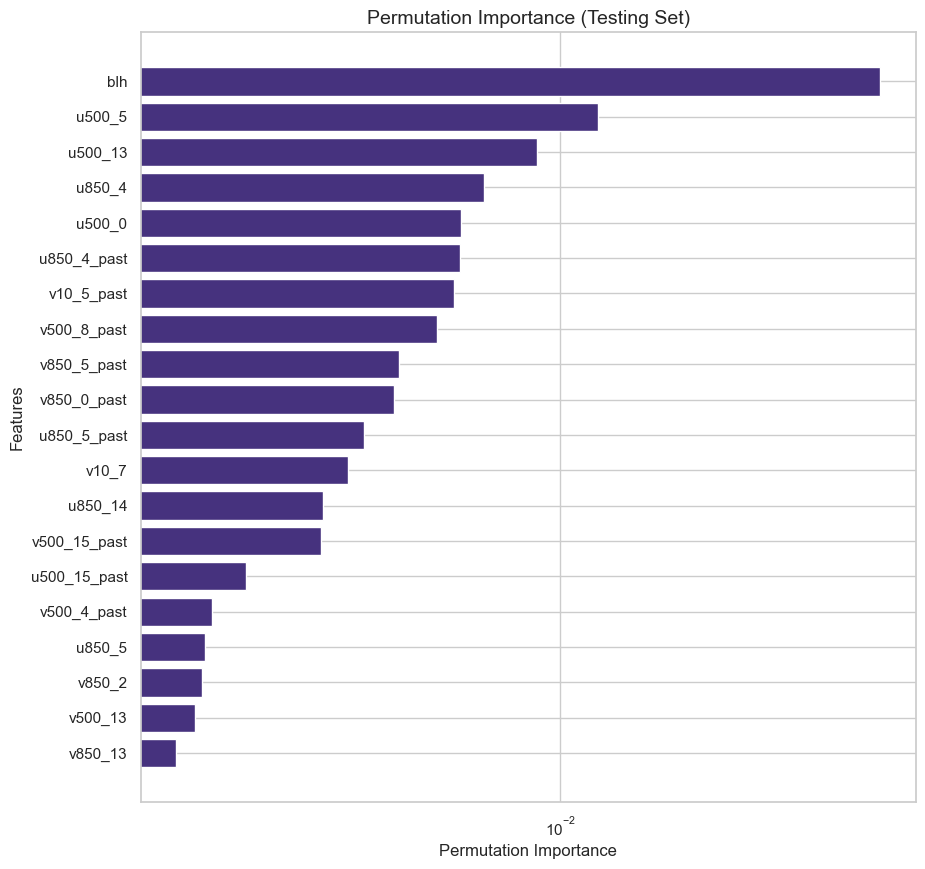

In [32]:
# plotting first 20 most important features in a histogram

fig, ax = plt.subplots(figsize=(10, 10))
sns.set(style="whitegrid")
sns.set_palette("viridis")

ax.barh(X_val.columns[sorted_importances][-20:], perm_importance.importances_mean[sorted_importances][-20:])

ax.set_xscale('log')

ax.set_ylabel('Features')
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance (Testing Set)', fontsize=14)